# Using Location Data and K-Means Clustering to determine the locations for a new Restaurant Chain and its Distribution Centres in New York City

**Data Science Capstone - IBM Data Science Specialization**

## Table of Contents
1. <a href="#1">Introduction / Business Problem</a>
1. <a href="#2">Data Selection - Import Relevant Data</a>
1. <a href="#3">Methodology</a>
1. <a href="#4">Exploratory Data Analysis</a>
1. <a href="#5">Results</a>
1. <a href="#6">Discussion</a>
1. <a href="#7">Conclusion</a>




##  1. Introduction / Business Problem <a id ="1">
There are already a multitude of restaurants, bars and lifestyle locations in New York City. Fierce competition can therefore be expected when opening new restaurants. To ensure business success it is crucial to determine the right location for the new venue taking into account the characteristics of the neighborhood, population and restaurant variety. The search for white spots where the expected demand is high, but the restaurant density that corresponds to the demand is still rather low increases the chances of a successful start.
This report examines how census and location data can be used to determine the locations of a new Chinese restaurant chain that wants to gain a foothold in the New York restaurant scene. These are the main questions that will be answered:
1.	**Which districts are the most promising to open up new Chinese restaurants?** 
2.	Having determined the new restaurant locations, the next step is to deal with logistic questions. A well-organized supply chain will not only ensure smooth supply of the restaurants but also reduce costs. Therefore, the question will be answered: **Which are the best places to set-up the distribution centres for supplying the restaurant chain?**


## 2. Data Selection - Import Relevant Data  <a id ="2">

#### Data selection:
1. Table of Neighborhoods per Borough (containing Latitutde, Longitude, Neighborhood, Borough)
2. Foursquare Location data (address, coordinates and neighborhood of the chinese restaurants in New York City)
3. Census data: Chinese population per New York Community District
4. Table of Neighborhoods per Community District to map census and foursquare data


In [2]:
# import libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# tranforming json file into a pandas dataframe library
from pandas import json_normalize

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of New York City.

In [3]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### 2.1 Neighborhood per borough
First a list with all neighborhoods of New York is downloaded. This is used for the Foursquare API requests and later on for mapping the Chinese restaurants to the census data. 

In [4]:
#load data
!wget -q -O newyork_data.json https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']
#neighborhoods_data[0]

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for i in range(len(neighborhoods_data)):
    borough = neighborhoods_data[i]['properties']['borough']
    neighborhood_name = neighborhoods_data[i]['properties']['annoline1']
    neighborhood_lat = neighborhoods_data[i]['geometry']['coordinates'][1]
    neighborhood_lon = neighborhoods_data[i]['geometry']['coordinates'][0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Drop duplicate neighborhoods
Some neighborhoods are listed twice in the dataframe. Therefore let's delete the duplicate entries:

In [8]:
neighborhoods.drop_duplicates(subset = 'Neighborhood', ignore_index = True, inplace = True)
neighborhoods.shape

(263, 4)

### 2.2 Foursquare data
Now we retrieve all Chinese restaurants in NY using the public Foursquare API.

#### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Get the Chinese restaurants from Foursquare API
Foursquare API has a limit of 50 per search request. Therefore, we retrieve the chinese restaurants using the coordinates of all neighborhoods separately and delete overlapping result sets afterwards.

CategoryId '4bf58dd8d48988d145941735' is used as filter to limit result set to category "Chinese Restaurant"

In [16]:
limit = 200
radius = 5000
categoryId = '4bf58dd8d48988d145941735'

venues_list=[]
for name, lat, lng in zip(neighborhoods['Neighborhood'], neighborhoods['Latitude'], neighborhoods['Longitude']):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        limit,
        categoryId)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    #results = requests.get(url).json()['response']['venues'] #own code

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

nearby_chin_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_chin_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']

In [1262]:
print("In total, {} Chinese restaurants were found. However, there are {} unique restaurant names, which indicates that the data includes several duplicates.".format(nearby_chin_venues.shape[0], len(nearby_chin_venues['Venue'].unique())))

In total, 26065 Chinese restaurants were found. However, there are 1863 unique restaurant names, which indicates that the data includes several duplicates.


#### Remove duplicates from dataframe:

In [1490]:
chinese_restaurants_w_dupl = nearby_chin_venues[['Venue', 'Venue Latitude','Venue Longitude','Venue Category']]
chinese_restaurants_w_dupl.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Peking Kitchen,40.854260,-73.866223,Chinese Restaurant
1,No. 1 Chinese Restaurant,40.895781,-73.805285,Chinese Restaurant
2,Mr. Q's Chinese Restaurant,40.855790,-73.855455,Chinese Restaurant
3,China Mia,40.858316,-73.867232,Chinese Restaurant
4,Jimmy's Best Chinese Restaurant,40.884179,-73.832685,Asian Restaurant


In [1264]:
chinese_restaurants= chinese_restaurants_w_dupl.drop_duplicates(ignore_index = True)
print("There are {} chinese restaurants in NY".format(chinese_restaurants.shape[0]))

There are 2205 chinese restaurants in NY


### 2.3 Census data
The Official Website of the City of New York offers access to the decennial census data, which is collected once a decade. This data includes the Asian population and selected subgroups per community district. For the analysis the data from 2000 is used which can be downloaded here: https://www1.nyc.gov/site/planning/data-maps/nyc-population/demo-tables-2000.page

In [1125]:
# Load data:
populationData = pd.read_excel('sf1p110.xls')
populationData.head()

,Community District,Asian Indian,Bangladeshi,Cambodian,Chinese,Filipino,Indonesian,Japanese,Korean,Malaysian,Pakistani,Sri Lankan,Thai,Vietnamese,Other Asian and Persons of Two or More Asian Categories
0,Bronx 1,174,3,0,144,92,1,19,19,0,2,0,1,22,29
1,Bronx 2,138,0,4,50,19,0,5,8,0,12,0,2,30,14
2,Bronx 3,98,0,5,65,51,0,7,8,0,5,0,29,42,15
3,Bronx 4,1274,183,0,265,139,2,32,57,0,13,6,47,49,106
4,Bronx 5,1186,156,70,198,237,1,13,38,5,12,1,50,85,132


Now, we only select the Chinese population and do some data cleaning which is necessary for the further analysis

In [1486]:
# for further analysis, only select chinese population
chinesePopulation = populationData[['Community District', 'Chinese']]

#data cleaning
chinesePopulation.loc[:,('Community District')] = chinesePopulation['Community District'].replace({"  ","   "}, " ", regex=True)

chinesePopulation.columns = ['Community District','Chinese Inhabitants']
chinesePopulation.iloc[20:25,:]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Community District,Chinese Inhabitants
20,Brooklyn 9,297
21,Brooklyn 10,12333
22,Brooklyn 11,34164
23,Brooklyn 12,16266
24,Brooklyn 13,5335


### 2.4 Neighborhood per community district
To match the census data with the neighborhood data a mapping table is needed to map neighborhoods and community districts. Such a table can be found on wikipedia: https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City

In [1290]:
## retrieve data from wikipedia
url = 'https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City'
#Read a URL and match a table that contains specific text:
match = 'Community Board'
data = pd.read_html(url,match=match)
communityDistrict_neighborhood = data[0]
communityDistrict_neighborhood.head()

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,91497,12761,"Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,5.54,52246,9792,"Hunts Point, Longwood"
2,Bronx CB 3,4.07,79762,19598,"Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,5.28,146441,27735,"Concourse, Highbridge"
4,Bronx CB 5,3.55,128200,36145,"Fordham, Morris Heights, Mount Hope, Universit..."


Now let's only select the relevant columns:

In [1489]:
df = communityDistrict_neighborhood[['Community Board(CB)', 'Neighborhoods']]
df.columns = ['Community District', 'Neighborhoods']
df.head()

,Community District,Neighborhoods
0,Bronx CB 1,"Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,"Hunts Point, Longwood"
2,Bronx CB 3,"Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,"Concourse, Highbridge"
4,Bronx CB 5,"Fordham, Morris Heights, Mount Hope, Universit..."


Rows that include NaN Value are deleted:

In [1291]:
communityDistrict_neighborhood.dropna(axis=0, inplace = True)
print("There are {} community districts in NY".format(communityDistrict_neighborhood.shape[0]))

There are 59 community districts in NY


Currently, the neighborhoods per community district are listed in one row and separated by a comma. Now, we split the neighborhoods and insert each neighborhood in a new row:

In [1292]:
#clean table and insert new row with short neighborhood name (for mapping later on)
column_names = ['Community District','Neighborhood']
district_nbhood_simplified = pd.DataFrame(columns = column_names)

for row in communityDistrict_neighborhood.iterrows():
    communityDistrict = row[1][0].replace("\xa0CB\xa0", " ")
    nbhoods = row[1][4]

    for j in range(0,len(nbhoods.split(','))):
        neighborhood = nbhoods.split(',')[j].strip()
        neighborhood_short = neighborhood.split(" ")[0]
        district_nbhood_simplified = district_nbhood_simplified.append({'Community District': communityDistrict,
                                                                        'Neighborhood': neighborhood,
                                            'Neighborhood_short': neighborhood_short}, ignore_index=True)

# some data cleaning:
district_nbhood_simplified['Neighborhood'].replace({'NoHo','SoHo','Bedford-Stuyvesant'}, {'Noho','Soho', 'Bedford Stuyvesant'}, inplace = True)
district_nbhood_simplified['Neighborhood_short'].replace({'NoHo','SoHo'}, {'Noho','Soho'}, inplace = True)
        
        
district_nbhood_simplified.head()

,Community District,Neighborhood,Neighborhood_short
0,Bronx 1,Melrose,Melrose
1,Bronx 1,Mott Haven,Mott
2,Bronx 1,Port Morris,Port
3,Bronx 2,Hunts Point,Hunts
4,Bronx 2,Longwood,Longwood


In total there are 315 neighborhoods in the table:

In [1294]:
district_nbhood_simplified.shape
len(district_nbhood_simplified['Neighborhood'].unique())

315

#### Combine datasets (Neighborhoods & Community Districts)

For further mapping we need to combine the dataset **district_nbhood_simplified** (neighborhood and community districts) with the dataset **neighborhoods** (neighborhood, latitude, longitude):

In [1295]:
#function to get community district
def get_community_district(row):
    neighborhood = row['Neighborhood']
    
    try:
        row_number = district_nbhood_simplified[district_nbhood_simplified['Neighborhood'] == neighborhood].index[0]
        community_district = district_nbhood_simplified.loc[row_number, 'Community District']
        return community_district.replace("\xa0", " ")
    
    except:
        try: 
            row_number = district_nbhood_simplified[district_nbhood_simplified['Neighborhood_short'] == neighborhood].index[0]
            community_district = district_nbhood_simplified.loc[row_number, 'Community District']
            return community_district.replace("\xa0", " ")
        
        except:
            return None
        

In [1296]:
nbhoods_districts = neighborhoods
nbhoods_districts['Community District'] = nbhoods_districts.apply(get_community_district, axis=1)
nbhoods_districts.head()

,Borough,Neighborhood,Latitude,Longitude,Community District
0,Bronx,Wakefield,40.894705,-73.847201,Bronx 12
1,Bronx,Co-op,40.874294,-73.829939,Bronx 10
2,Bronx,Eastchester,40.887556,-73.827806,Bronx 12
3,Bronx,Fieldston,40.895437,-73.905643,Bronx 8
4,Bronx,Riverdale,40.890834,-73.912585,Bronx 8


#### Delete neighborhoods that could not be assigned to a commmunity district
Some neighborhoods were not included in the community district table. Without a community district, we cannot use this dataset in the further analyis.

In [1297]:
nbhoods_districts[nbhoods_districts['Community District'].isnull()].shape

(28, 5)

28 neighborhoods could not be assigned to a community district. This rows will be excluded from the dataset:

In [1298]:
nbhoods_districts.dropna(axis=0, inplace = True)
nbhoods_districts.shape

(235, 5)

## 3. Methodology  <a id ="3">

To get insights in the gathered data, the first step is using exploratory data analysis and data visualization. The locations of existing Chinese restaurants in New York are displayed on maps using the Folium Python library. K-nearest neighbor algorithm is used to determine the neighborhood of each Chinese restaurant.  Then, the restaurants are clustered by neighborhood and community district to investigate the density of restaurants. 
  
Subsequently, the restaurant density is compared to the Chinese residents living in the same community district. To estimate the likelihood of success for a new restaurant the following ratio is applied: Number of Chinese restaurants per 1,000 Chinese inhabitants. A low ratio refers to a promising district where supply is rather low compared to the demand, whereas a high ratio indicates a saturated restaurant – population relation.
  
In total, the new restaurant chain wants to open 15 new Chinese restaurants in New York. Therefore, the 15 community districts with the lowest ratio of Chinese restaurants / 1,000 Chinese inhabitants are selected from the dataset. Within the selected community district, the neighborhood with the least Chinese restaurant are assigned as the new location for a Chinese restaurant.
  
Having determined the most promising locations to open the restaurants, the next step is to find the best location to set-up the distribution centers for supplying the restaurant chain. This is done by applying K-means clustering. In total, 3 distribution centers shall be established.  The coordinates of the selected restaurant locations are used to cluster the restaurants and define the best locations for the new distribution centers. 


## 4. Exploratory Data Analysis  <a id ="4">

To get insights in the gathered data, the first step is using exploratory data analysis and data visualization. The locations of existing Chinese restaurants in New York are displayed on maps using the Folium Python library. 

#### Now let's visualize all restaurants on a map:


In [1317]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [1502]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, neigh, district in zip(chinese_restaurants['Venue Latitude'], 
                                              chinese_restaurants['Venue Longitude'], 
                                              chinese_restaurants['Neighborhood'], 
                                              chinese_restaurants['Community District']):
    label = folium.Popup(str(neigh) + ' Community District ' + str(district), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=0.01,
        popup=label,
        color = '#304ffe',
        fill=True,
        fill_color='#304ffe',
        fill_opacity=0.6).add_to(map_clusters)

map_clusters

## 5. Results  <a id ="5">
    
This chapter is divided in to parts:  
+ In Part 1 the locations for the new Chinese restaurants are determined.  
+ In Part 2 the locations for the distribution centers are determined.

## Part 1: Determine locations for new Chinese restaurants
In total, the restaurant chain wants to open 15 new Chinese restaurants. Therefore, the best neighborhoods to set-up these restaurants have to be found. 
1. Assign Chinese Restaurants to Neighborhood and Community District by using K-nearest neighbor
2. Calculate ratio of restaurants / Chinese population per Community District
3. Find the 15 community districts with the lowest ratio. Within the community district assign the neighborhood with the least chinese restaurant as the new location.



###  Assign Chinese Restaurants to Neighborhood and Community District by using K-nearest neighbor

Using k-nearest neighbor algorithm each Chinese restaurant is assigned to the closest neighborhood. Then, the neighborhoods are grouped by community district and the results displayed in a map. 

In [1307]:
from sklearn.datasets import make_blobs 
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

#Train model based on coordinates of neighborhoods
X = nbhoods_districts[['Latitude','Longitude']]
Y = nbhoods_districts[['Neighborhood','Community District']]
neigh = KNeighborsClassifier(n_neighbors = 1).fit(X,Y)

#use predict to get neighborhoods of chinese restaurants (neighborhood with the closest coordinates)
X_chinRest = chinese_restaurants[['Venue Latitude', 'Venue Longitude']]
yhat = neigh.predict(X_chinRest)

#convert into dataframe
nearest_neighborhoods = pd.DataFrame(data = yhat)
nearest_neighborhoods.head()

,0,1
0,Bronxdale,Bronx 11
1,Eastchester,Bronx 12
2,Pelham Parkway,Bronx 11
3,Bronxdale,Bronx 11
4,Eastchester,Bronx 12


In [1311]:
# add nearest neighborhoods to chinese restaurants dataframe:
chinese_restaurants.loc[:,'Neighborhood'] = nearest_neighborhoods[0]
chinese_restaurants.loc[:,'Community District'] = nearest_neighborhoods[1]
chinese_restaurants.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Community District
0,Peking Kitchen,40.854260,-73.866223,Chinese Restaurant,Bronxdale,Bronx 11
1,No. 1 Chinese Restaurant,40.895781,-73.805285,Chinese Restaurant,Eastchester,Bronx 12
2,Mr. Q's Chinese Restaurant,40.855790,-73.855455,Chinese Restaurant,Pelham Parkway,Bronx 11
3,China Mia,40.858316,-73.867232,Chinese Restaurant,Bronxdale,Bronx 11
4,Jimmy's Best Chinese Restaurant,40.884179,-73.832685,Asian Restaurant,Eastchester,Bronx 12


#### Chinese restaurants grouped by community district:
Now we group the chinese restaurants by community district to get an insight about the density of restaurant in different districts:

In [1319]:
restaurants_per_district = chinese_restaurants[['Community District', 'Venue']].groupby(['Community District']).count()
restaurants_per_district.columns = ['Number Chinese Restaurants']
restaurants_per_district.reset_index(inplace=True)

restaurants_per_district.sort_values(by='Number Chinese Restaurants', ascending = False, inplace = True)
restaurants_per_district.head()

,Community District,Number Chinese Restaurants
49,Queens 7,136
14,Brooklyn 11,113
42,Queens 13,102
31,Manhattan 2,93
40,Queens 11,85


The most Chinese restaurants are in the Community Districts Queens 7, Brooklyn 11 and Manhattan 2. In the next step these numbers are divided by the Chinese population in these areas for further analysis.

#### Plot the number of restaurants per community district: 

In [1320]:
# function to get latitude and longitude for community district:
def get_latitude_district(row):
    community_district = row['Community District']
    neighborhoods = nbhoods_districts[nbhoods_districts['Community District']== community_district].reset_index(drop=True)
    latitude = neighborhoods.loc[0,'Latitude']
    return latitude

def get_longitude_district(row):
    community_district = row['Community District']
    neighborhoods = nbhoods_districts[nbhoods_districts['Community District']== community_district].reset_index(drop=True)
    longitude = neighborhoods.loc[0,'Longitude']
    return longitude

In [1321]:
restaurants_per_district['Latitude']=restaurants_per_district.apply(get_latitude_district, axis = 1)
restaurants_per_district['Longitude']=restaurants_per_district.apply(get_longitude_district, axis = 1)

restaurants_per_district.head()

,Community District,Number Chinese Restaurants,Latitude,Longitude
49,Queens 7,136,40.764454,-73.831773
14,Brooklyn 11,113,40.611009,-73.995180
42,Queens 13,102,40.749441,-73.715481
31,Manhattan 2,93,40.715618,-73.994279
40,Queens 11,85,40.766041,-73.774274


To display circles of different sizes according to the number of Chinese restaurants, we have to normalize the numbers of Chinese restaurants:

In [1322]:
#normalize number_restaurants
norm_restaurants = (restaurants_per_district['Number Chinese Restaurants'] - 
                    restaurants_per_district['Number Chinese Restaurants'].min())/(restaurants_per_district['Number Chinese Restaurants'].max() - 
                                                                                     restaurants_per_district['Number Chinese Restaurants'].min())

In [1484]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
from folium.features import DivIcon

# add markers to the map
for lat, lon, district, number, number_norm in zip(restaurants_per_district['Latitude'], 
                                              restaurants_per_district['Longitude'], 
                                              restaurants_per_district['Community District'], 
                                              restaurants_per_district['Number Chinese Restaurants'],
                                                  norm_restaurants):
    label = folium.Popup('Chinese restaurants in ' + str(district) + ': ' +str(number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=number_norm*15,
        label = number,
        popup=label,
        color = '#304ffe',
        fill=True,
        fill_color='#304ffe',
        fill_opacity=0.6).add_to(map_clusters)


map_clusters


### Calculate ratio of restaurants / Chinese population per Community District

To define which neighborhoods are the best locations for opening up new restaurants we first have to merge the two datasets 'Restaurants per District' and 'Chinese Population'. Then we can visualize the Chinese inhabitants and Chinese restaurants per district.  
To determine the districts with the lowest density of Chinese restaurants compared to its Chinese inhabitants, the following ratio for each community district will be calculated in the second step: Chinese restaurants / 1.000 Chinese inhabitants. 


In [1505]:
# Step 1: merge restaurants_per_district with census data
restaurants_per_district_merged = restaurants_per_district.merge(chinesePopulation, on = 'Community District', how='left')
restaurants_per_district_merged.head()

,Community District,Number Chinese Restaurants,Latitude,Longitude,Chinese Inhabitants
0,Queens 7,136,40.764454,-73.831773,41777
1,Brooklyn 11,113,40.611009,-73.995180,34164
2,Queens 13,102,40.749441,-73.715481,1840
3,Manhattan 2,93,40.715618,-73.994279,9720
4,Queens 11,85,40.766041,-73.774274,14619


Now we want to display  the number of Chinese residents on the same map as the number of restaurants. By doing so, we can compare the restaurant densitiy to the population in that area.  
First, we also need to normalize the Chinese population data for plotting:

In [1506]:
#normalize chinese population
norm_chinese = (restaurants_per_district_merged['Chinese Inhabitants'] - 
                    restaurants_per_district_merged['Chinese Inhabitants'].min())/(restaurants_per_district_merged['Chinese Inhabitants'].max() - 
                                                                                     restaurants_per_district_merged['Chinese Inhabitants'].min())

In [1507]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
from folium.features import DivIcon

# add markers to the map
for lat, lon, district, number, number_norm, chinese_norm, chinese in zip(restaurants_per_district_merged['Latitude'], 
                                              restaurants_per_district_merged['Longitude'], 
                                              restaurants_per_district_merged['Community District'], 
                                              restaurants_per_district_merged['Number Chinese Restaurants'],
                                                norm_restaurants, norm_chinese,
                                                restaurants_per_district_merged['Chinese Inhabitants'],):
    label = folium.Popup(str(number) + ' in District: ' + str(district), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=number_norm*15,
        label = number,
        popup=label,
        color = '#304ffe',
        fill=True,
        fill_color='#304ffe',
        fill_opacity=0.6).add_to(map_clusters)

    
    label1 = folium.Popup('Chinese inhabitants in ' + str(district) + ': '+ str(chinese), parse_html=True)
    folium.CircleMarker(
        [lat+0.005, lon+0.005],
        radius=chinese_norm*15,
        label = chinese,
        popup=label1,
        color = '#8bc34a',
        fill=True,
        fill_color='#8bc34a',
        fill_opacity=0.6).add_to(map_clusters)


map_clusters


The following insights can be obtained by comparing the restaurant density and the population data:
1.	There is a positive correlation between the Chinese population and restaurant density which is the natural result of demand and supply.  
2.	There are districts with a high density of Chinese restaurant, but comparably few Chinese residents. These districts can be considered as less promising for the establishment of new restaurants, as there is already a high supply for the existing demand in this area.  
  
3.	Thus, the focus of the new restaurant chain should be on districts with a small number of restaurants compared to the respective Chinese population. These districts may be seen as white spots where supply in the area has not yet fully met existing demand.      
 

To quantify the strength of the relationship between Chinese inhabitants and number of Chinese restaurants, which we have seen on the map before, the Pearsson Correlation Coefficient is calculated:

In [1508]:
from scipy.stats import pearsonr 
no_restaurants = restaurants_per_district_merged['Number Chinese Restaurants']
no_inhabitants = restaurants_per_district_merged['Chinese Inhabitants']

corr, _ = pearsonr(no_restaurants, no_inhabitants)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.587


Now, for each community district the ratio between the Chinese restaurants per 1,000 Chinese inhabitants will be  calculated:

In [1509]:

# Step 2: Calculate ratio of restaurants / Chinese population per Community District
restaurants_per_district_merged['Restaurants / 1.000 Chinese'] = restaurants_per_district_merged['Number Chinese Restaurants'] / restaurants_per_district_merged['Chinese Inhabitants']*1000
restaurants_per_district_merged.head()

,Community District,Number Chinese Restaurants,Latitude,Longitude,Chinese Inhabitants,Restaurants / 1.000 Chinese
0,Queens 7,136,40.764454,-73.831773,41777,3.255380
1,Brooklyn 11,113,40.611009,-73.995180,34164,3.307575
2,Queens 13,102,40.749441,-73.715481,1840,55.434783
3,Manhattan 2,93,40.715618,-73.994279,9720,9.567901
4,Queens 11,85,40.766041,-73.774274,14619,5.814351


Now let's plot the ratio between restaurants and inhabitants:

Text(0.5, 0, 'Chinese restaurants / 1.000 Chinese inhabitants')

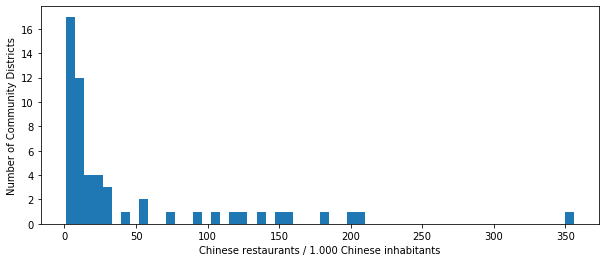

In [1510]:
import matplotlib.pyplot as plt

ax = restaurants_per_district_merged['Restaurants / 1.000 Chinese'].plot(kind='hist',figsize=(10, 4), bins=56)
ax.grid(False)
#plt.title('Histogram of Chinese restaurants / 1.000 Chinese inhabitants per neighboorhood')
plt.ylabel('Number of Community Districts')
plt.xlabel('Chinese restaurants / 1.000 Chinese inhabitants')


The range of Chinese restaurants / 1,000 Chinese inhabitants ranges from 1 up to 350. However, the districts with ratios above 50 can be considered as outliers as most districts range between 1 and 30. The selection of locations for new Chinese restaurants should be therefore focused on districts with a ratio below 10. 

### Get the 15 best locations (neighborhoods) for the new restaurants
Find the community districts with the lowest ratio. The 15 districts with the lowest ratio will be the selected locations for the new restaurants as there is a low number of restaurants compared to chinese population in that area.  
As the community districts are a rather large area, the neighborhood with the fewest chinese restaurants within the community district will be set as the new location.

In [1511]:
#Step 1: Sort by ratio and get the 15 districts with the lowest ratio
restaurants_per_district_merged.sort_values(by= 'Restaurants / 1.000 Chinese', ascending = True, inplace = True)

selected_districts = restaurants_per_district_merged[['Community District',
                                                     'Number Chinese Restaurants',
                                                     'Chinese Inhabitants',
                                                     'Restaurants / 1.000 Chinese']].head(15).reset_index(drop=True)
selected_districts

,Community District,Number Chinese Restaurants,Chinese Inhabitants,Restaurants / 1.000 Chinese
0,Brooklyn 12,21,16266,1.291037
1,Queens 4,33,21714,1.519757
2,Brooklyn 13,9,5335,1.686973
3,Queens 6,25,12374,2.020365
4,Brooklyn 14,11,4235,2.597403
5,Manhattan 1,11,4040,2.722772
6,Brooklyn 15,44,15390,2.858999
7,Queens 2,22,7600,2.894737
8,Queens 7,136,41777,3.255380
9,Brooklyn 11,113,34164,3.307575


In [1512]:
# Step2: Select neighborhoods with the least chinese restaurants in that community district as the new location

#get number of restaurants per neighborhood
restaurants_per_neighborhoods = chinese_restaurants[['Neighborhood','Community District', 'Venue']].groupby(['Neighborhood','Community District']).count()
restaurants_per_neighborhoods.columns = ['Number Chinese Restaurants']
restaurants_per_neighborhoods.reset_index(inplace = True)
restaurants_per_neighborhoods.head()


,Neighborhood,Community District,Number Chinese Restaurants
0,Allerton,Bronx 11,5
1,Arden,Staten Island 3,3
2,Arlington,Staten Island 1,23
3,Arrochar,Staten Island 2,1
4,Arverne,Queens 14,2


Now that we selecte the community districts with the lowest and therefore best ratio of restaurants per 1000 Chinese residents, we need to define one neighborhood within the district as the new location. The neighborhood with the fewest Chinese restaurants is selected as the new location. This is based on the assumption that competition in this neighborhood is relatively low which increases the chance of a successful launch. Finally, the selected neighborhoods for the new restaurant locations are plotted on the New York Map. 

In [1328]:
#function to get best neighborhood in community district:
def get_best_neighborhood(row):
    community_district = row['Community District']

    neighborhoods = restaurants_per_neighborhoods[restaurants_per_neighborhoods['Community District']== community_district]
    neighborhoods_min_restaurants= neighborhoods[neighborhoods['Number Chinese Restaurants'] == neighborhoods['Number Chinese Restaurants'].min()].reset_index(drop=True) 
    return neighborhoods_min_restaurants.loc[0,'Neighborhood']

In [1438]:
# get neighborhoods with the least restaurant in the selected community districts
selected_districts['Neighborhood'] = selected_districts.apply(get_best_neighborhood, axis = 1)
selected_districts

,Community District,Number Chinese Restaurants,Chinese,Restaurants / 1.000 Chinese,Neighborhood
0,Brooklyn 12,21,16266,1.291037,Midwood
1,Queens 4,33,21714,1.519757,Corona
2,Brooklyn 13,9,5335,1.686973,Sea
3,Queens 6,25,12374,2.020365,Forest
4,Brooklyn 14,11,4235,2.597403,Flatbush
5,Manhattan 1,11,4040,2.722772,Tribeca
6,Brooklyn 15,44,15390,2.858999,Gerritsen
7,Queens 2,22,7600,2.894737,Hunters
8,Queens 7,136,41777,3.255380,Malba
9,Brooklyn 11,113,34164,3.307575,Gravesend


In [1439]:
## get coordinates of the neighborhoods
selected_columns = ['Neighborhood', 'Borough','Latitude','Longitude']
selected_locations = selected_districts.merge(neighborhoods[selected_columns], on = 'Neighborhood', how= 'left')
selected_locations

,Community District,Number Chinese Restaurants,Chinese,Restaurants / 1.000 Chinese,Neighborhood,Borough,Latitude,Longitude
0,Brooklyn 12,21,16266,1.291037,Midwood,Brooklyn,40.625596,-73.957595
1,Queens 4,33,21714,1.519757,Corona,Queens,40.742382,-73.856825
2,Brooklyn 13,9,5335,1.686973,Sea,Brooklyn,40.576375,-74.007873
3,Queens 6,25,12374,2.020365,Forest,Queens,40.725264,-73.844475
4,Brooklyn 14,11,4235,2.597403,Flatbush,Brooklyn,40.636326,-73.958401
5,Manhattan 1,11,4040,2.722772,Tribeca,Manhattan,40.721522,-74.010683
6,Brooklyn 15,44,15390,2.858999,Gerritsen,Brooklyn,40.590848,-73.930102
7,Queens 2,22,7600,2.894737,Hunters,Queens,40.743414,-73.953868
8,Queens 7,136,41777,3.255380,Malba,Queens,40.790602,-73.826678
9,Brooklyn 11,113,34164,3.307575,Gravesend,Brooklyn,40.595260,-73.973471


#### Plot the selected locations:

In [1503]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.2)

# add markers to the map
for lat, lon, neigh in zip(selected_locations['Latitude'], 
                                              selected_locations['Longitude'], 
                                              selected_locations['Neighborhood']):
    label = folium.Popup(str(neigh), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = '#304ffe',
        fill=True,
        fill_color='#304ffe',
        fill_opacity=0.6).add_to(map_clusters)
    
        
    folium.map.Marker(
    [lat+0.005, lon+0.01],
    icon=DivIcon(
        icon_size=(50,10),
        icon_anchor=(0,0),
        html='<div style="font-size: 8pt; color:blue; background-color:white">%s</div>' % neigh,
        )
    ).add_to(map_clusters)

map_clusters

## Part 2: Using K-means clustering to determine the distribution center locations
To ensure food supply of the new restaurant locations, 3 distribution centre will be built in New York. The locations of these distribution centers have to be determined. 

In [1394]:
cluster_dataset = selected_locations[['Latitude','Longitude']]

#### Modeling: 
Now let's cluster the locations into 3 clusters. The centroid of each cluster will be the distribution centres. 

In [1402]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
selected_locations['Cluster Labels'] = labels


# get latitude and longitude of centers
column_names = ['Latitude', 'Longitude']
centers = pd.DataFrame(columns = column_names)
for cluster_center in k_means.cluster_centers_:
    latitude = cluster_center[0]
    longitude = cluster_center[1]
    centers = centers.append({'Latitude': latitude, 'Longitude': longitude}, ignore_index=True) 

centers.reset_index(inplace = True)
centers.rename(columns={'index':'Center Number'}, inplace = True)
centers

,Center Number,Latitude,Longitude
0,0,40.613559,-73.967919
1,1,40.752409,-73.814384
2,2,40.787279,-73.957397


### Now visualize the locations of the distribution centers

In [1410]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters+4)
ys = [i + x + (i*x)**2 for i in range(num_clusters+4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
for lat, lon, poi, cluster in zip(selected_locations['Latitude'], selected_locations['Longitude'], selected_locations['Neighborhood'], selected_locations['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lon, num in zip(centers['Latitude'], centers['Longitude'], centers['Center Number']):
    label = folium.Popup('Distribution Center '+ str(num), parse_html=True)
    folium.Marker(
        [lat, lon],
        radius=5,
        popup=label).add_to(map_clusters)
    
map_clusters

## 6. Discussion <a id ="6">
In the methodology and result section it was shown how to use location data and enrich them by combining other datasets (e.g. census data). As indicator for selecting the new restaurant locations the ratio between Chinese restaurant density and the Chinese population was used. This ratio is a good starting point to select the most promising districts, but also has some limitations. For reason of simplification, it was assumed that demand for Chinese restaurants only comes from the Chinese residents living in that area. Tourists or the demand of other population groups living in that area were not considered.  In a more detailed analysis, the factors increasing the demand for Chinese restaurants should therefore be diversified. This also includes the overall density of restaurants in the areas, the proximity to the adjacent Chinese restaurants as well the proximity of public transport or parking options.   
  
Based on the selected restaurant locations, the distribution center locations were determined using K-Means Clustering, which is one the simplest and most popular unsupervised machine learning algorithms. The algorithm was used to divide the selected restaurant locations in 3 distinct non-overlapping subgroups which are called clusters. A cluster refers to a collection of data points aggregated together because of certain similarities. In this case, the location data of the selected restaurants was used as similarity to minimize the distance within the clusters. Using location data for determining the distribution centers helps determining the approximate area to set up the distribution center. As a next step, it is recommended to take further factors into consideration. These include the proximity to high-ways and big distribution points and the average traffic volume in that area. Other factors as rental costs or availability of qualified workforce might also be important. 



## 7. Conclusion <a id ="7">
This report showed how to leverage location data to determine new restaurant locations in a city. By enriching these data with additional data, the gain in knowledge can be significantly increased. In order to obtain first insights into the available data, an explorative data analysis was conducted.  Machine learning algorithms such as K-nearest neighbor and K-means clustering were deployed to cluster the data and find the distribution center locations for the new restaurant chain. The limitations of the analysis were also outlined in the discussion section. It is recommended to overcome these limitations by including additional factors in the further analysis. 